# TODO
- Do more searching if there is time
- Explore test_regression_anal
- Documentation on all functions
- Fix array names
- move the grid_search to utils.py

# Part a): Write your own Stochastic Gradient Descent code, first step
In order to get started, we will now replace in our standard ordinary least squares (OLS) and Ridge regression codes (from project 1) the matrix inversion algorithm with our own gradient descent (GD) and SGD codes. You can use the Franke function or the terrain data from project 1. However, we recommend using a simpler function like a higher-order one-dimensional polynomials. You can obviously test your final codes against for example the Franke function.

The exercise set for week 41 should help in solving this part of the project.

You should include in your analysis of the GD and SGD codes the following elements

### 0. Imports and Setup

In [1]:
from pathlib import Path
project_root_dir = Path.cwd().parent
fig_dir = project_root_dir / 'figs'
from wand.image import Image


import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from utils import optimal_parameters, plot_mse_contour, FrankeFunction, parameter_print_plot
plt.rcParams.update({'text.usetex': True, 'font.size': 18, 'font.family': 'serif', 'font.serif': 'Computer Modern Sans Serif', 'font.weight': 100, 'mathtext.fontset': 'cm', 'xtick.labelsize': 16, 'ytick.labelsize': 16})
import numpy as np
from RegressionModel import RegressionModel
from tqdm import tqdm
seed = 42
np.random.seed(seed)

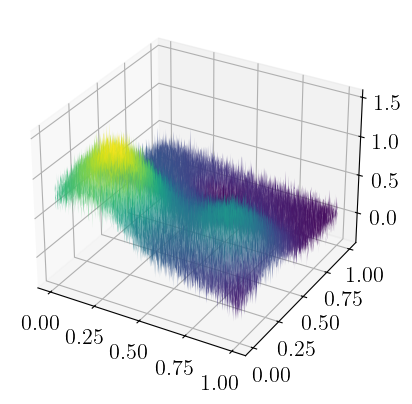

In [2]:
N  = 1000
x = np.arange(0, 1, 1/N).reshape(-1, 1)
y = np.arange(0, 1, 1/N).reshape(-1, 1)
X, Y = np.meshgrid(x, y)

noise = 0.1
z = FrankeFunction(X, Y, noise, seed).reshape(-1, 1)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, z.reshape(N, N), cmap='viridis')
plt.show()

In [3]:
degree = 4
test_size = 0.2
model = RegressionModel(x, y, degree, test_size, seed=seed)

### 1. A plain gradient descent with a fixed learning rate (you will need to tune it) using the analytical expression for the gradient.

Minimum MSE:  6.751e-03
Optimal learning rate:  2.456e-01


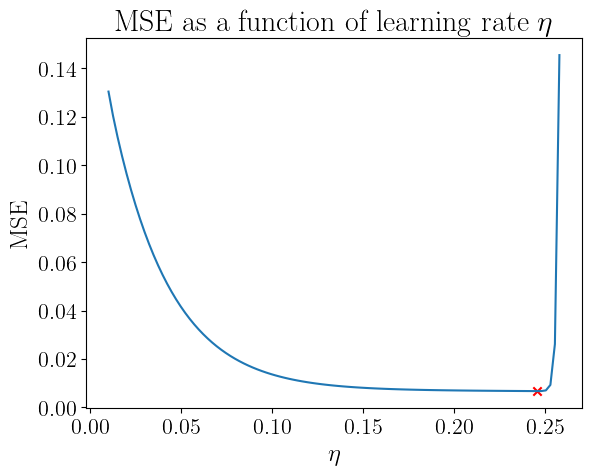

In [5]:
MSE_array_plain = []
param2_array = np.linspace(0.01, 0.258, 101)
for η in param2_array:
    MSE, R2 = model.gradient_descent(50, eta=η)
    MSE_array_plain.append(MSE)
print(f'Minimum MSE: {min(MSE_array_plain): .3e}')
print(f'Optimal learning rate: {param2_array[np.argmin(MSE_array_plain)]: .3e}')

plt.plot(param2_array, MSE_array_plain)
plt.scatter(param2_array[np.argmin(MSE_array_plain)], min(MSE_array_plain), color='red', label='Minimum MSE', marker='x')
plt.xlabel(r'$\eta$')
plt.ylabel('MSE')
plt.title(r'MSE as a function of learning rate $\eta$')
plt.savefig(fig_dir / 'MSE_eta_plain.pdf')
plt.show()

#### Comment
- When increasing the learning rate, we see a decrease in the MSE. 
- It stabilizes right before  0.25, and increases sharply thereafter.  

### 2. Add momentum to the plain GD code and compare convergence with a fixed learning rate (you may need to tune the learning rate). Keep using the analytical expression for the gradient.


In [6]:
def grid_search(x_array: tuple,  y_array: tuple, search_params_name: tuple, method: str,  model,  stochastic: bool = False, n_iterations: int = 100, **kwargs):
    nx = len(x_array) ; ny = len(y_array)
    MSE_array = np.zeros((nx, ny))
    R2_array = np.zeros((nx, ny))
    
    if stochastic:
        descent = model.stochastic_gradient_descent
    else:
        descent = model.gradient_descent
    
    for i, x in enumerate(tqdm(x_array)):
        for j, y in enumerate(y_array):
            param_dict = {param_name: x if i == 0 else y for i, param_name in enumerate(search_params_name) if isinstance(param_name, str)}
            param_dict.update({param_name: y for _, param_name in enumerate(search_params_name) if isinstance(param_name, tuple) for param_name in param_name})
            MSE, R2 = descent(n_iterations, **param_dict , tuning_method=method, **kwargs)
            MSE_array[i, j] = MSE
            R2_array[i, j] = R2
    
    return  MSE_array, R2_array

In [27]:
n = 50
n_iterations = 100
γ_plain = np.linspace(0.875, 0.925, n)
η_plain= np.linspace(0.375, 0.425, n)
MSE_plain, R2_plain = grid_search(η_plain, γ_plain, ('eta', 'gamma'), 'Momentum', model)
# MSE_array_momentum = np.zeros((len(η_array), len(γ_array)))
# R2_array_momentum = np.zeros((len(η_array), len(γ_array)))

# for i, η in enumerate(tqdm(η_array)):
#     for j, γ in enumerate(γ_array):
#         MSE, R2 = model.gradient_descent(n_iterations, gamma=γ, eta=η, tuning_method='Momentum')
#         MSE_array_momentum[i, j] = MSE
#         R2_array_momentum[i, j] = R2

100%|██████████| 50/50 [00:20<00:00,  2.48it/s]


#### Tuning both the learning rate and the momentum parameter

##### Overview of entire parameter space

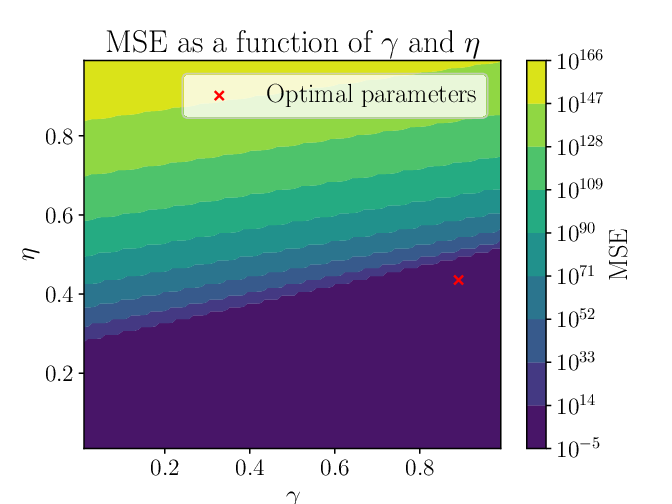

In [5]:
img = Image(filename= fig_dir / 'a_2_parameter_overview.pdf', resolution=105)
img

##### Tuned parameters

Minimum MSE:        1.946e-05
Optimal η for MSE:  4.066e-01
Optimal γ for MSE:  9.066e-01

Maximum R2:          100.00%
Optimal η for R2:  4.066e-01
Optimal γ for R2:  9.066e-01


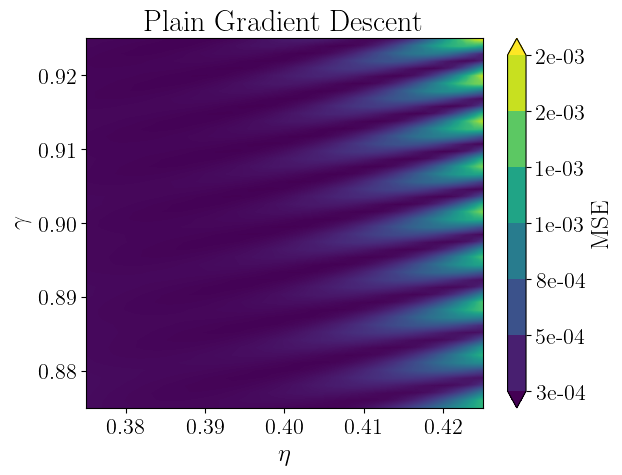

In [42]:
fig = parameter_print_plot(MSE_plain, R2_plain, η_plain, γ_plain, r'$\eta$', r'$\gamma$')
plt.title('Plain Gradient Descent')
fig.savefig(fig_dir / 'GD_eta_gamma.pdf')

#### Comment
- By trial and error, we closed in on the optimal parameters.
- Minimum MSE: 1.947e-03
    - Optimal η for MSE:  4.173e-01
    - Optimal γ for MSE:  9.066e-01
- Maximum R2:  100.00%
    - Optimal η for R2:  4.173e-01
    - Optimal γ for R2:  9.066e-01
- With $γ > 0.90$, we see long "hairs" of regions with higher MSE. This could suggest it would be wise to stay a bit further left of the optimal γ (0.875 to 0.90), to avoid these regions. Given a slightly different starting point, we could find our optimal parameters to suddenly be in this region.   
- The optimal $η$-values was not that important. 

 ### 3. Repeat these steps for stochastic gradient descent with mini batches and a given number of epochs. Use a tunable learning rate as discussed in the lectures from weeks 39 and 40. Discuss the results as functions of the various parameters (size of batches, number of epochs etc). Use the analytical gradient.

#### 3.a Fixed learning rate

In [44]:
n = 50
n_iterations = 100
dx = N/100
batch_stochastic = np.arange(5, 40 + dx, dx, dtype=int)
η_stochastic = np.linspace(0.1, 0.2, n)
# MSE_stochastic, R2_stochastic = grid_search(batch_stochastic, η_stochastic, ('M', 'eta'), 'Momentum', model, stochastic=True)
MSE_stochastic = np.zeros((len(η_stochastic), len(batch_stochastic)))
R2_stochastic = np.zeros((len(η_stochastic), len(batch_stochastic)))
for i, η in enumerate(tqdm(η_stochastic)):
    for j, m in enumerate(batch_stochastic):
        MSE, R2 = model.stochastic_gradient_descent(n_iterations, M=m, eta=η)
        MSE_stochastic[i, j] = MSE
        R2_stochastic[i, j] = R2

100%|██████████| 50/50 [00:10<00:00,  4.78it/s]


Minimum MSE:        1.594e-05
Optimal η for MSE:           2.000e-01
Optimal batch for MSE:   5
Maximum R2:          100.00%
Optimal η for R2:  2.000e-01
Optimal batch for R2:  5.000e+00


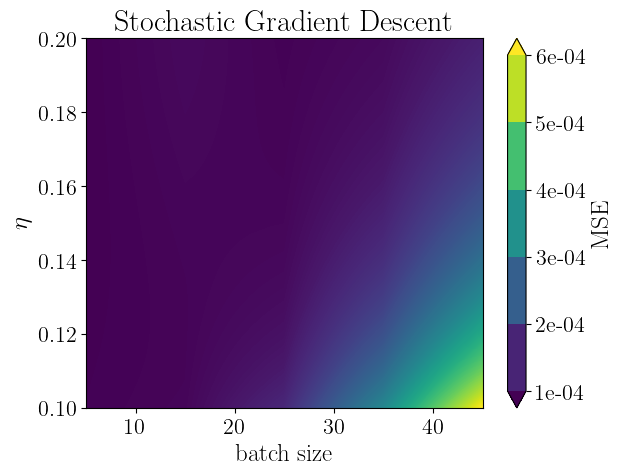

In [46]:
# MSE_stochastic = MSE_stochastic.T
batch_optimal_MSE, η_optimal_MSE = optimal_parameters(MSE_stochastic, batch_stochastic, η_stochastic)
batch_optimal_R2, η_optimal_R2 = optimal_parameters(R2_stochastic, batch_stochastic, η_stochastic, max_or_min='max')

print(f'Minimum MSE: {np.nanmin(MSE_stochastic):>16.3e}')
print(f'Optimal η for MSE: {η_optimal_MSE:>19.3e}')
print(f'Optimal batch for MSE: {batch_optimal_MSE: >3}')

print(f'Maximum R2: {np.nanmax(R2_stochastic):>16.2%}')
print(f'Optimal η for R2: {η_optimal_R2: 3.3e}')
print(f'Optimal batch for R2: {batch_optimal_R2: 3.3e}')
fig = plot_mse_contour(MSE_stochastic, batch_stochastic, "batch size", η_stochastic, r"$\eta$")
plt.title('Stochastic Gradient Descent')
fig.savefig(fig_dir / 'SGD_batch_eta_.pdf')

#### 3.b Tuning the learning rate

In [47]:
n = 50
n_iterations = 100
dx = N/100
η = 0.2
batch_array = np.arange(2, 20 + dx, dx, dtype=int)
γ_array = np.linspace(0.5, 0.99, n)
MSE_array_stochastic_momentum = np.zeros((len(γ_array), len(batch_array)))
R2_array_stochastic_momentum = np.zeros((len(γ_array), len(batch_array)))
for i, γ in enumerate(tqdm(γ_array)):
    for j, M in enumerate(batch_array):
        MSE, R2 = model.stochastic_gradient_descent(n_iterations, M=M, gamma=γ, eta=η)
        MSE_array_stochastic_momentum[i, j] = MSE
        R2_array_stochastic_momentum[i, j] = R2

100%|██████████| 50/50 [00:15<00:00,  3.23it/s]


Minimum MSE: 5.722256898106168e-06
Optimal γ for MSE:  5.000e-01
Optimal batch for MSE:  2.000e+00
Maximum R2:  100.00%
Optimal γ for R2:  5.000e-01
Optimal batch for R2:  2.000e+00


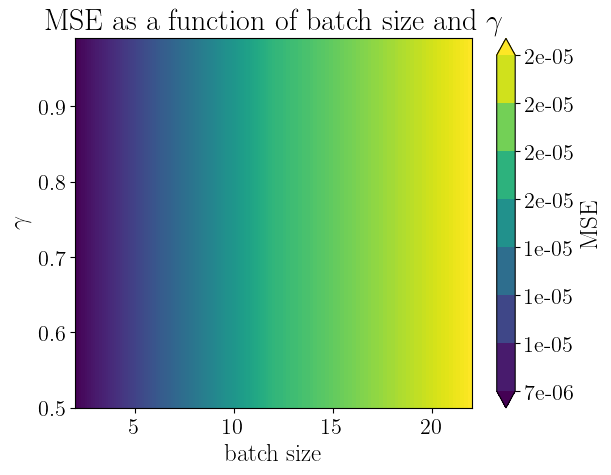

In [ ]:
fig = parameter_print_plot(MSE_array_stochastic_momentum, γ_array, batch_array, 'MSE', r'$\gamma$', 'batch size')
fig.savefig(fig_dir / 'SGD_batch_gamma.pdf')

##### Comment
- If this is correct, we should have a small learning rate, and small batch size. 
- This is most likely not correct, as it should take shorter time to compute, as the batch size gets larger. This is the opposite of what we see.

### 4. Implement the Adagrad method in order to tune the learning rate. Do this with and without momentum for plain gradient descent and SGD.


#### 4.a No momentum

In [8]:
n_iterations = 100
n = 101
MSE_Ada = []
MSE_Ada_stochastic = []
η_Ada = np.linspace(0.1, 0.8, n)
for η in tqdm(η_Ada):
    MSE, R2 = model.gradient_descent(n_iterations, eta=η, tuning_method='AdaGrad')
    MSE_stochastic, R2_stochastic = model.stochastic_gradient_descent(n_iterations, M=10, eta=η, tuning_method='AdaGrad')
    MSE_Ada.append(MSE)
    MSE_Ada_stochastic.append(MSE_stochastic)

100%|██████████| 101/101 [00:09<00:00, 10.74it/s]


Minimum MSE:  6.135e-03
Optimal learning rate:  2.750e-01
Minimum MSE stochastic:  2.225e-05
Optimal learning rate stochastic:  6.250e-01


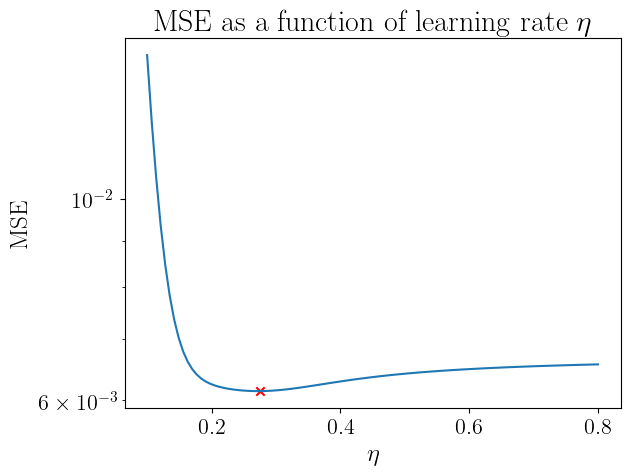

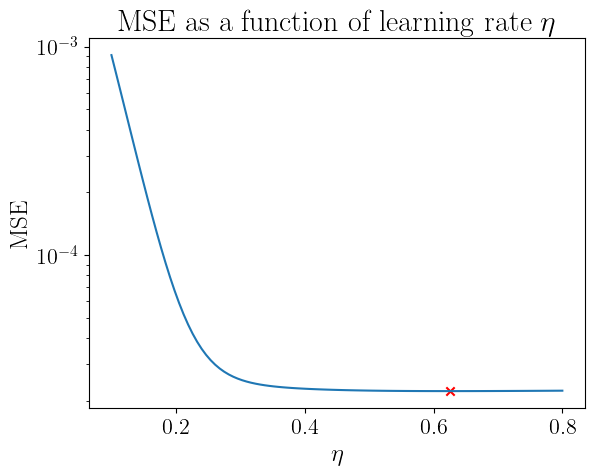

In [9]:

print(f'Minimum MSE: {min(MSE_Ada): .3e}')
print(f'Optimal learning rate: {η_Ada[np.argmin(MSE_Ada)]: .3e}')

print(f'Minimum MSE stochastic: {min(MSE_Ada_stochastic): .3e}')
print(f'Optimal learning rate stochastic: {η_Ada[np.argmin(MSE_Ada_stochastic)]: .3e}')

plt.semilogy(η_Ada, MSE_Ada)
plt.scatter(η_Ada[np.argmin(MSE_Ada)], min(MSE_Ada), color='red', label='Minimum MSE', marker='x')
plt.xlabel(r'$\eta$')
plt.ylabel('MSE')
plt.title(r'MSE as a function of learning rate $\eta$')
plt.show()


plt.semilogy(η_Ada, MSE_Ada_stochastic)
plt.scatter(η_Ada[np.argmin(MSE_Ada_stochastic)], min(MSE_Ada_stochastic), color='red', label='Minimum MSE', marker='x')
plt.xlabel(r'$\eta$')
plt.ylabel('MSE')
plt.title(r'MSE as a function of learning rate $\eta$')
plt.show()

#### 4.b Momentum
##### Gradient Descent

100%|██████████| 50/50 [00:26<00:00,  1.90it/s]


In [ ]:
# n = 50
# n_iterations = 100
# # γ_array = np.linspace(0.2, 0.6, n)
# # η_array = np.linspace(0.8, 0.99, n)
# MSE_array_Ada_mom = np.zeros((len(η_array), len(γ_array)))
# R2_array_Ada_mom = np.zeros((len(η_array), len(γ_array)))

# for i, η in enumerate(tqdm(η_array)):
#     for j, γ in enumerate(γ_array):
#         MSE, R2 = model.gradient_descent(n_iterations, gamma=γ, eta=η, tuning_method='AdagradMomentum')
#         MSE_array_Ada_mom[i, j] = MSE
#         R2_array_Ada_mom[i, j] = R2


n = 50
η_array = np.linspace(0.2, 0.45, n)
γ_array = np.linspace(0.8, 0.99, n)
method = 'AdagradMomentum'
MSE_array_Ada_mom, R2_array_Ada_mom = grid_search(η_array, γ_array, ('eta', 'gamma'), method=method, model=model)


100%|██████████| 50/50 [00:28<00:00,  1.77it/s]


Minimum MSE:        1.155e-03
Optimal η for MSE:  4.939e-01
Optimal γ for MSE:  9.357e-01

Maximum R2:           99.88%
Optimal η for R2:  4.939e-01
Optimal γ for R2:  9.357e-01


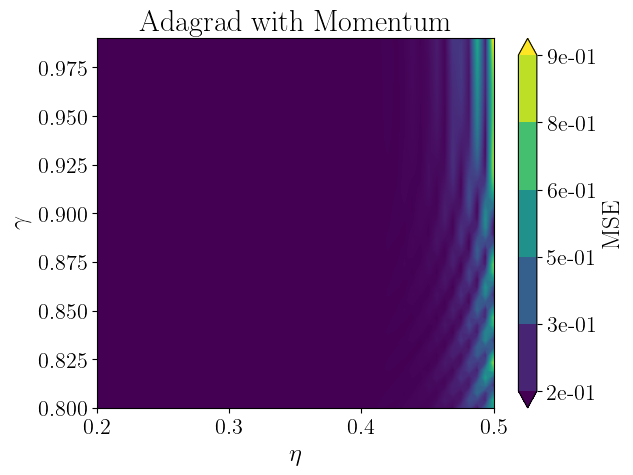

In [14]:
fig = parameter_print_plot(MSE_array_Ada_mom, R2_array_Ada_mom, η_array, γ_array, r"$\eta$", r"$\gamma$")
plt.title('Adagrad with Momentum')
plt.savefig(fig_dir / 'AdagradMomentum_eta_gamma.pdf')

In [ ]:
n = 50
η_array = np.linspace(0.2, 0.4, n)
γ_array = np.linspace(0.8, 0.99, n)
method = 'AdagradMomentum'
MSE_array_Ada_mom, R2_array_Ada_mom = grid_search(η_array, γ_array, ('eta', 'gamma'), method=method, model=model)

100%|██████████| 50/50 [00:22<00:00,  2.21it/s]


Minimum MSE:        1.464e-03
Optimal η for MSE:  3.796e-01
Optimal γ for MSE:  8.931e-01

Maximum R2:           99.85%
Optimal η for R2:  3.796e-01
Optimal γ for R2:  8.931e-01


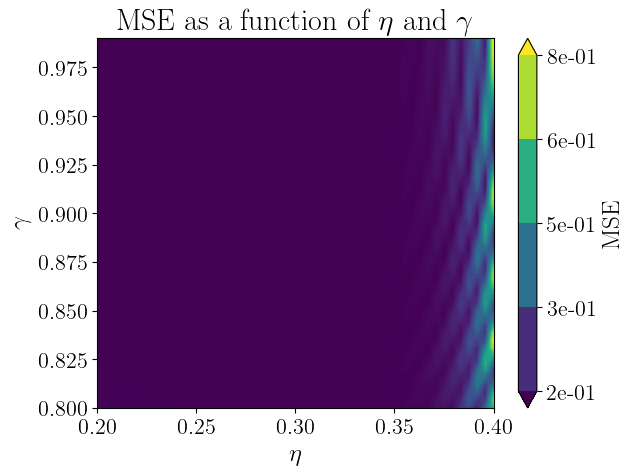

In [17]:
fig = parameter_print_plot(MSE_array_Ada_mom, R2_array_Ada_mom, η_array, γ_array, r"$\eta$", r"$\gamma$")
fig.savefig(fig_dir / 'AdagradMomentum_stochastic_eta_gamma.pdf')

### 5. Add RMSprop and Adam to your library of methods for tuning the learning rate.

#### 5.a RMSprop

In [19]:
n = 50
n_iterations = 100
η_array_RMS = np.linspace(0.1, 0.8, n)
ρ_array_RMS = np.linspace(0.0000001, 0.001, n)
MSE_array_RMS, R2_array_RMS = grid_search(η_array_RMS, ρ_array_RMS, ('eta', 'rho_1'), method='RMS_Prop', model=model)
# MSE_array_RMS = np.zeros((len(η_array_RMS), len(ρ_array_RMS)))
# R2_array_RMS = np.zeros((len(η_array_RMS), len(ρ_array_RMS)))
# for i, η in enumerate(tqdm(η_array_RMS)):
#     for j, ρ in enumerate(ρ_array_RMS):
#         MSE, R2 = model.gradient_descent(n_iterations, eta=η, tuning_method='RMS_Prop', tuning_params=ρ)
#         MSE_array_RMS[i, j] = MSE
#         R2_array_RMS[i, j] = R2

100%|██████████| 50/50 [00:21<00:00,  2.35it/s]


Minimum MSE:        2.477e-02
Optimal η for MSE:  1.143e-01
Optimal ρ for MSE:  1.633e-04

Maximum R2:           97.46%
Optimal η for R2:  1.143e-01
Optimal ρ for R2:  1.633e-04


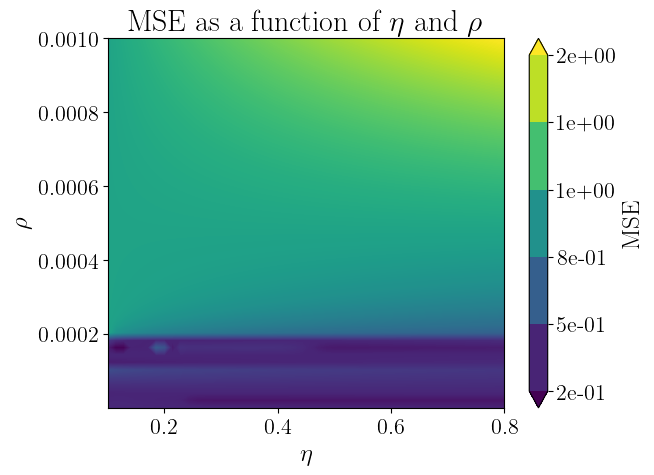

In [20]:
fig = parameter_print_plot(MSE_array_RMS, R2_array_RMS, η_array_RMS, ρ_array_RMS, r"$\eta$", r"$\rho$")
fig.savefig(fig_dir / 'RMS_Prop_eta_rho.pdf')
plt.show()

In [ ]:
n = 50
n_iterations = 100
η_RMS_stochastic = np.linspace(0.1, 0.8, n)
ρ_RMS_stochastic = np.linspace(0.01, 0.1, n)
MSE_RMS_stochastic, R2_RMS_stochastic = grid_search(η_RMS_stochastic, ρ_RMS_stochastic, ('eta', 'rho_1'), method='RMS_Prop', model=model, stochastic=True, M=10)
# MSE_array_RMS_stochastic = np.zeros((len(η_array_RMS_stochastic), len(ρ_array_RMS_stochastic)))
# R2_array_RMS_stochastic = np.zeros((len(η_array_RMS_stochastic), len(ρ_array_RMS_stochastic)))
# for i, η in enumerate(tqdm(η_array_RMS_stochastic)):
#     for j, ρ in enumerate(ρ_array_RMS_stochastic):
#         MSE, R2 = model.stochastic_gradient_descent(n_iterations, M=20, eta=η, tuning_method='RMS_Prop', tuning_params=ρ)
#         MSE_array_RMS_stochastic[i, j] = MSE
#         R2_array_RMS_stochastic[i, j] = R2


100%|██████████| 50/50 [03:36<00:00,  4.32s/it]


Minimum MSE:        4.122e-02
Optimal η for MSE:  8.000e-01
Optimal ρ for MSE:  1.000e-02

Maximum R2:           95.78%
Optimal η for R2:  8.000e-01
Optimal ρ for R2:  1.000e-02


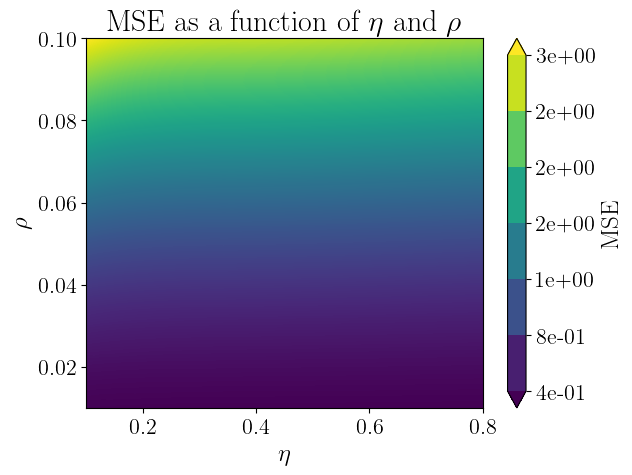

In [26]:
fig = parameter_print_plot(MSE_RMS_stochastic, R2_RMS_stochastic, η_RMS_stochastic, ρ_RMS_stochastic, r"$\eta$", r"$\rho$")
fig.savefig(fig_dir / 'RMS_Prop_stochastic_eta_rho.pdf')

In [28]:

print(f'Minimum MSE: {min(MSE_array_RMS): .3e}')
print(f'Optimal learning rate: {η_array[np.argmin(MSE_array_RMS)]: .3e}')
print(f'Minimum MSE stochastic: {min(MSE_array_RMS_stochastic): .3e}')
print(f'Optimal learning rate stochastic: {η_array[np.argmin(MSE_array_RMS_stochastic)]: .3e}')

plt.semilogy(η_array, MSE_array_RMS)
plt.scatter(η_array[np.argmin(MSE_array_RMS)], min(MSE_array_RMS), color='red', label='Minimum MSE', marker='x')
plt.xlabel(r'$\eta$')
plt.ylabel('MSE')
plt.title(r'MSE as a function of learning rate $\eta$')
plt.show()


plt.semilogy(η_array, MSE_array_RMS_stochastic)
plt.scatter(η_array[np.argmin(MSE_array_RMS_stochastic)], min(MSE_array_RMS_stochastic), color='red', label='Minimum MSE', marker='x')
plt.xlabel(r'$\eta$')
plt.ylabel('MSE')
plt.title(r'MSE as a function of learning rate $\eta$')
plt.show()

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

#### 5.b Adam

In [30]:
n_iterations = 100
n = 50
η_Adam = np.linspace(0.4, 0.8, n)
ρ_Adam = np.linspace(0.001, .9, n)
MSE_Adam, R2_Adam = grid_search(η_Adam, ρ_Adam, ('eta', ('rho_1', 'rho_2')), method='Adam', model=model)
# MSE_array_Adam = np.zeros((len(η_array_Adam), len(ρ_array_Adam)))
# R2_array_Adam = np.zeros((len(η_array_Adam), len(ρ_array_Adam)))
# for i, η in enumerate(tqdm(η_array_Adam)):
#     for j, ρ in enumerate(ρ_array_Adam):
#         MSE, R2 = model.gradient_descent(n_iterations, eta=η, tuning_method='Adam', tuning_params=(ρ, ρ))
#         MSE_array_Adam[i, j] = MSE
#         R2_array_Adam[i, j] = R2

100%|██████████| 50/50 [00:24<00:00,  2.01it/s]


Minimum MSE:        8.427e-05
Optimal η for MSE:  7.918e-01
Optimal ρ for MSE:  8.450e-01

Maximum R2:           99.99%
Optimal η for R2:  7.918e-01
Optimal ρ for R2:  8.450e-01


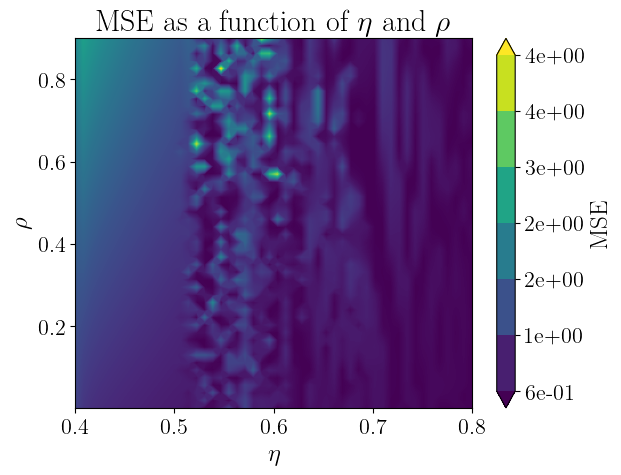

In [31]:
fig = parameter_print_plot(MSE_Adam, R2_Adam, η_Adam, ρ_Adam, r"$\eta$", r"$\rho$")
# fig.savefig(fig_dir / 'Adam_eta_rho.pdf')
plt.show()

In [33]:
n_iterations = 100
n = 50
η_Adam_stochastic = np.linspace(0.4, 0.8, n)
ρ_Adam_stochastic = np.linspace(0.001, .9, n)
MSE_Adam_stochastic, R2_Adam_stochastic = grid_search(η_Adam_stochastic, ρ_Adam_stochastic, ('eta', ('rho_1', 'rho_2')), method='Adam', model=model, stochastic=True, M=10)

100%|██████████| 50/50 [04:30<00:00,  5.41s/it]


Minimum MSE:        1.115e-04
Optimal η for MSE:  7.918e-01
Optimal ρ for MSE:  3.679e-01

Maximum R2:           99.99%
Optimal η for R2:  7.918e-01
Optimal ρ for R2:  3.679e-01


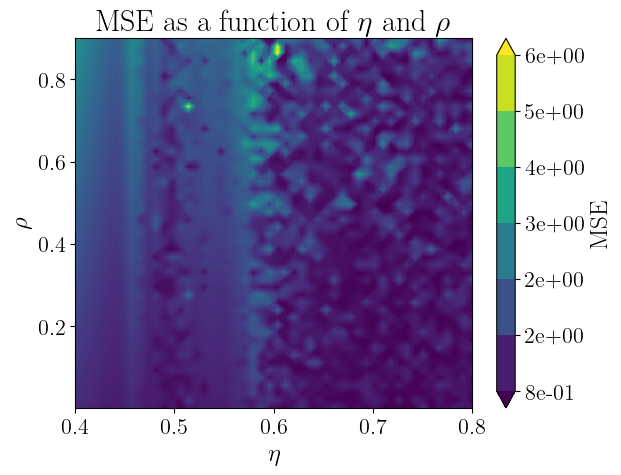

In [34]:
fig = parameter_print_plot(MSE_Adam_stochastic, R2_Adam_stochastic, η_Adam_stochastic, ρ_Adam_stochastic, r"$\eta$", r"$\rho$")
fig.savefig(fig_dir / 'Adam_stochastic_eta_rho.pdf')
plt.show()

In [ ]:
n_iterations = 100
n = 101
MSE_array_Adam = []
MSE_array_Adam_stochastic = []
η_array = np.linspace(0.001, 0.2, n)
for η in tqdm(η_array):
    MSE, R2 = model.gradient_descent(n_iterations, eta=η, tuning_method='Adam', tuning_params = [0.2, 0.2])
    MSE_stochastic, R2_stochastic = model.stochastic_gradient_descent(n_iterations, M=10, eta=η, tuning_method='Adam', tuning_params = [0.2, 0.2])
    MSE_array_Adam.append(MSE)
    MSE_array_Adam_stochastic.append(MSE_stochastic)

100%|██████████| 101/101 [00:27<00:00,  3.68it/s]


Minimum MSE:  9.190e-03
Optimal learning rate:  1.891e-02
Minimum MSE stochastic:  1.998e-05
Optimal learning rate stochastic:  3.881e-02


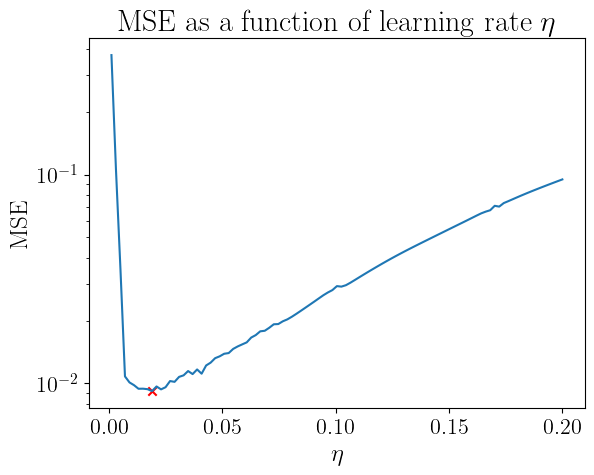

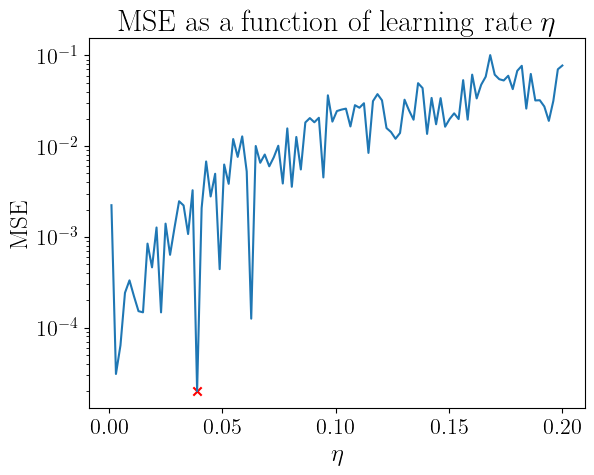

In [ ]:

print(f'Minimum MSE: {min(MSE_array_Adam): .3e}')
print(f'Optimal learning rate: {η_array[np.argmin(MSE_array_Adam)]: .3e}')
print()
print(f'Minimum MSE stochastic: {min(MSE_array_Adam_stochastic): .3e}')
print(f'Optimal learning rate stochastic: {η_array[np.argmin(MSE_array_Adam_stochastic)]: .3e}')

plt.semilogy(η_array, MSE_array_Adam)
plt.scatter(η_array[np.argmin(MSE_array_Adam)], min(MSE_array_Adam), color='red', label='Minimum MSE', marker='x')
plt.xlabel(r'$\eta$')
plt.ylabel('MSE')
plt.title(r'MSE as a function of learning rate $\eta$')
plt.show()


plt.semilogy(η_array, MSE_array_Adam_stochastic)
plt.scatter(η_array[np.argmin(MSE_array_Adam_stochastic)], min(MSE_array_Adam_stochastic), color='red', label='Minimum MSE', marker='x')
plt.xlabel(r'$\eta$')
plt.ylabel('MSE')
plt.title(r'MSE as a function of learning rate $\eta$')
plt.show()